# Notebook Contents

- [Imports](#Imports)
- [Data](#Data)
- [Preprocessing](#Preprocessing)
    - [Multicolinearity - VIF](#Multicolinearity---VIF)
- [Clustering](#Clustering)
    - [4-Seam Fastball](#4-Seam-Fastball)
        - [4-Seam Cluster Label](#Cluster-Labels---4-Seam)
    - [Slider](#Slider)
        - [Slider Cluster Label](#Cluster-Labels---Slider)
    - [Changeup](#Changeup)
        - [Changeup Cluster Label](#Cluster-Labels---Changeup)
    - [Cutter](#Cutter)
        - [Cutter Cluster Label](#Cluster-Labels---Cutter)

# Imports

In [1]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, k_means
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.feature_selection import SelectKBest
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score

import warnings
warnings.filterwarnings('ignore')

# Data

In [2]:
data = pd.read_csv('../data/mlb-pitches.csv')
data.drop(columns = ['Unnamed: 0', 'Unnamed: 0.1'], inplace = True) 
data = data[['pitch_type','release_speed', 'release_spin_rate', 'spin_axis', 'pfx_-x', 'pfx_z', 'bauer_units', 
             'effective_speed', 'release_pos_x', 'release_pos_z', 'release_extension', 'release_pos_y',
             'swing_miss', 'delta_run_exp', 'hit_distance_sc', 'launch_speed', 'launch_angle', 
             'estimated_ba_using_speedangle', 'estimated_woba_using_speedangle', 'woba_value', 
             'woba_denom', 'babip_value', 'iso_value', 'launch_speed_angle', 'vy0', 'vz0', 'ax', 'ay', 
             'az', 'player_name']]

# data['stand'] = data['stand'].map({'R': 0, 'L': 1})
# data['p_throws'] = data['p_throws'].map({'R': 0, 'L': 1})

data[['hit_distance_sc', 'launch_speed', 'launch_angle', 'estimated_ba_using_speedangle', 
      'estimated_woba_using_speedangle', 'woba_value', 'woba_denom', 'babip_value', 'iso_value', 
      'launch_speed_angle']] = data[['hit_distance_sc', 'launch_speed', 'launch_angle', 
                                     'estimated_ba_using_speedangle', 'estimated_woba_using_speedangle', 
                                     'woba_value', 'woba_denom', 'babip_value', 'iso_value', 
                                     'launch_speed_angle']].fillna(value = 0)
data = data[(data['pitch_type'] != 'KC') & (data['pitch_type'] != 'FS')]
data.dropna(inplace = True)

pd.set_option('max_columns', None)
print(data.shape)
data.head(3)

(680887, 30)


,pitch_type,release_speed,release_spin_rate,spin_axis,pfx_-x,pfx_z,bauer_units,effective_speed,release_pos_x,release_pos_z,release_extension,release_pos_y,swing_miss,delta_run_exp,hit_distance_sc,launch_speed,launch_angle,estimated_ba_using_speedangle,estimated_woba_using_speedangle,woba_value,woba_denom,babip_value,iso_value,launch_speed_angle,vy0,vz0,ax,ay,az,player_name
0,FF,92.3,2330.0,148.0,-8.28,16.56,25.243770,92.8,1.40,6.80,6.5,54.03,0,-0.073,13.0,95.2,-13.0,0.174,0.158,0.0,1.0,0.0,0.0,2.0,-134.166485,-7.361843,9.708393,26.562803,-14.083224,"Smith, Will"
1,SL,80.6,2254.0,315.0,9.24,5.76,27.965261,81.2,1.60,6.64,6.4,54.15,0,-0.027,108.0,75.3,75.0,0.000,0.000,0.0,0.0,0.0,0.0,0.0,-117.430885,-3.266842,-6.531123,19.793390,-27.369114,"Smith, Will"
2,CU,75.5,1940.0,328.0,7.80,-6.12,25.695364,75.2,1.46,6.88,6.2,54.34,0,-0.020,157.0,83.5,65.0,0.000,0.000,0.0,0.0,0.0,0.0,0.0,-109.901781,-1.155694,-4.872924,20.602334,-36.262184,"Smith, Will"


Pitch Types:

4-Seam, Cutter, Sinker, Slider, Curveball, Changeup

In [3]:
ff = data.loc[data['pitch_type'] == 'FF']
fc = data.loc[data['pitch_type'] == 'FC']
si = data.loc[data['pitch_type'] == 'SI']
sl = data.loc[data['pitch_type'] == 'SL']
cu = data.loc[data['pitch_type'] == 'CU']
ch = data.loc[data['pitch_type'] == 'CH']

# Preprocessing

### Multicolinearity - VIF

In [4]:
#features = data.select_dtypes([np.number])
#vif_data = pd.DataFrame()
#vif_data["feature"] = features.columns
#
#vif_data["VIF"] = [variance_inflation_factor(features.values, i)
#                   for i in range(len(features.columns))]
#
#vif_data.sort_values(by = 'VIF').head(15)

# Features

In [5]:
# Based on VIF
# features = data[['swing_miss', 'launch_angle', 'release_pos_x', 'delta_run_exp', 'babip_value', 'woba_denom',
#                  'launch_speed', 'iso_value', 'hit_distance_sc', 'vz0', 'launch_speed_angle']]

# My features
# features = data[['swing_miss', 'launch_angle', 'delta_run_exp', 'babip_value',
#                  'launch_speed', 'iso_value', 'launch_speed_angle', 'woba_value', 'spin_axis',
#                  'estimated_ba_using_speedangle', 'estimated_woba_using_speedangle', 
#                  'release_speed', 'release_spin_rate', 'spin_axis', 'pfx_-x', 'pfx_z', 'bauer_units']]

# Clustering 

## 4-Seam Fastball

In [6]:
features_ff = ff.select_dtypes([np.number])
X_ff = features_ff

ss = StandardScaler()
X_ff_scaled = ss.fit_transform(X_ff)
X_ff_scaled[:,:] *= -1

pca = PCA().fit(X_ff_scaled)
principal_components_ff = pca.transform(X_ff_scaled)
model_ff = pd.DataFrame(data = principal_components_ff, columns = X_ff.columns)

km_ff = KMeans(n_clusters = 2, 
               random_state = 1)
km_ff.fit(model_ff)
label_ff = km_ff.fit_predict(model_ff)

print('Number of iterations:', km_ff.n_iter_)
print('Number of features:', km_ff.n_features_in_)
print('Number of clusters:', km_ff.n_clusters)
print('Inertia:', km_ff.inertia_, '\n')
print("Predicted clusters to points: ", label_ff[:10], '\n')
#centroids = km_ff.cluster_centers_
#print("Location of centroids: ")
#print(centroids)

Number of iterations: 15
Number of features: 28
Number of clusters: 2
Inertia: 5895994.348853472 

Predicted clusters to points:  [1 1 1 1 1 1 1 1 1 1] 



### Cluster Labels - 4-Seam

In [7]:
# 0 bad, 1 good

X_ff['label'] = label_ff
model_ff['label'] = label_ff
#model_ff.groupby(by = 'label').mean().T
X_ff.groupby(by = 'label').mean().T

label,0,1
release_speed,93.556401,93.710868
release_spin_rate,2257.786943,2274.381550
spin_axis,192.891401,192.837758
pfx_-x,2.844573,2.840705
pfx_z,15.620324,16.134162
bauer_units,24.135076,24.272376
effective_speed,93.688115,93.826254
release_pos_x,-0.687649,-0.703116
release_pos_z,5.925394,5.915844
release_extension,6.359127,6.368151


## Cutter

In [8]:
features_fc = fc.select_dtypes([np.number])
X_fc = features_fc

X_fc_scaled = ss.fit_transform(X_fc)
X_fc_scaled[:,:] *= -1

pca = PCA().fit(X_fc_scaled)
principal_components_fc = pca.transform(X_fc_scaled)
model_fc = pd.DataFrame(data = principal_components_fc, columns = X_fc.columns)

km_fc = KMeans(n_clusters = 2, 
               random_state = 1)

km_fc.fit(model_fc)
label_fc = km_fc.fit_predict(model_fc)

print('Number of iterations:', km_fc.n_iter_)
print('Number of features:', km_fc.n_features_in_)
print('Number of clusters:', km_fc.n_clusters)
print('Inertia:', km_fc.inertia_, '\n')
print("Predicted clusters to points: ", label_fc[:10], '\n')

Number of iterations: 6
Number of features: 28
Number of clusters: 2
Inertia: 1117733.03559108 

Predicted clusters to points:  [0 0 0 0 0 0 0 0 1 0] 



### Cluster Labels - Cutter

In [9]:
# 0 good, 1 bad

X_fc['label'] = label_fc
model_fc['label'] = label_fc

X_fc.groupby(by = 'label').mean().T

label,0,1
release_speed,88.539208,88.353926
release_spin_rate,2370.035784,2359.673620
spin_axis,174.392128,174.403681
pfx_-x,-1.393469,-1.208724
pfx_z,7.928322,7.863497
bauer_units,26.778950,26.719458
effective_speed,88.739718,88.547331
release_pos_x,-0.436232,-0.313663
release_pos_z,5.901746,5.900669
release_extension,6.261665,6.246135


# Sinker

In [10]:
features_si = si.select_dtypes([np.number])
X_si = features_si

X_si_scaled = ss.fit_transform(X_si)
X_si_scaled[:,:] *= -1

pca = PCA().fit(X_si_scaled)
principal_components_si = pca.transform(X_si_scaled)
model_si = pd.DataFrame(data = principal_components_si, columns = X_si.columns)

km_si = KMeans(n_clusters = 2, 
               random_state = 1)

km_si.fit(model_si)
label_si = km_si.fit_predict(model_si)

print('Number of iterations:', km_si.n_iter_)
print('Number of features:', km_si.n_features_in_)
print('Number of clusters:', km_si.n_clusters)
print('Inertia:', km_si.inertia_, '\n')
print("Predicted clusters to points: ", label_si[:10], '\n')

Number of iterations: 16
Number of features: 28
Number of clusters: 2
Inertia: 2580742.591614861 

Predicted clusters to points:  [0 0 0 0 0 0 0 0 0 0] 



### Cluster Labels - Sinker

In [11]:
# 0 good, 1 bad

X_si['label'] = label_si
model_si['label'] = label_si

X_si.groupby(by = 'label').mean().T

label,0,1
release_speed,93.023103,92.831956
release_spin_rate,2124.536704,2112.028115
spin_axis,194.721315,194.920485
pfx_-x,5.654472,5.571199
pfx_z,9.256429,8.948634
bauer_units,22.840969,22.753357
effective_speed,93.009219,92.815066
release_pos_x,-0.655328,-0.659924
release_pos_z,5.730877,5.729415
release_extension,6.309325,6.283539


## Slider

In [12]:
features_sl = sl.select_dtypes([np.number])
X_sl = features_sl

X_sl_scaled = ss.fit_transform(X_sl)
X_sl_scaled[:,:] *= -1

pca = PCA().fit(X_sl_scaled)
principal_components_sl = pca.transform(X_sl_scaled)
model_sl = pd.DataFrame(data = principal_components_sl, columns = X_sl.columns)

km_sl = KMeans(n_clusters = 2, 
               random_state = 1)

km_sl.fit(model_sl)
label_sl = km_sl.fit_predict(model_sl)

print('Number of iterations:', km_sl.n_iter_)
print('Number of features:', km_sl.n_features_in_)
print('Number of clusters:', km_sl.n_clusters)
print('Inertia:', km_sl.inertia_, '\n')
print("Predicted clusters to points: ", label_sl[:10], '\n')

Number of iterations: 5
Number of features: 28
Number of clusters: 2
Inertia: 3187660.3080025828 

Predicted clusters to points:  [0 0 0 0 0 0 0 0 0 0] 



### Cluster Labels - Slider

In [13]:
# 0 good, 1 bad

X_sl['label'] = label_sl
model_sl['label'] = label_sl

X_sl.groupby(by = 'label').mean().T

label,0,1
release_speed,84.654736,84.608851
release_spin_rate,2418.570549,2398.822464
spin_axis,145.813369,145.390401
pfx_-x,-3.229375,-3.104561
pfx_z,1.708910,1.621314
bauer_units,28.612703,28.391837
effective_speed,84.720893,84.714676
release_pos_x,-0.931662,-0.935459
release_pos_z,5.794148,5.817366
release_extension,6.259251,6.242978


# Curveball

In [14]:
features_cu = cu.select_dtypes([np.number])
X_cu = features_cu

X_cu_scaled = ss.fit_transform(X_cu)
X_cu_scaled[:,:] *= -1

pca = PCA().fit(X_cu_scaled)
principal_components_cu = pca.transform(X_cu_scaled)
model_cu = pd.DataFrame(data = principal_components_cu, columns = X_cu.columns)

km_cu = KMeans(n_clusters = 2, 
               random_state = 1)

km_cu.fit(model_cu)
label_cu = km_cu.fit_predict(model_cu)

print('Number of iterations:', km_cu.n_iter_)
print('Number of features:', km_cu.n_features_in_)
print('Number of clusters:', km_cu.n_clusters)
print('Inertia:', km_cu.inertia_, '\n')
print("Predicted clusters to points: ", label_cu[:10], '\n')

Number of iterations: 20
Number of features: 28
Number of clusters: 2
Inertia: 1377791.1107620872 

Predicted clusters to points:  [0 0 0 0 0 0 0 0 0 0] 



### Cluster Labels - Curveball

In [15]:
# 0 good, 1 bad

X_cu['label'] = label_cu
model_cu['label'] = label_cu

X_cu.groupby(by = 'label').mean().T

label,0,1
release_speed,78.758759,78.514894
release_spin_rate,2508.111175,2486.347712
spin_axis,124.598760,125.687263
pfx_-x,-3.859604,-3.905509
pfx_z,-8.737887,-8.783294
bauer_units,31.894358,31.726756
effective_speed,78.486484,78.265695
release_pos_x,-0.517177,-0.495940
release_pos_z,5.975076,5.983264
release_extension,6.209101,6.191781


## Changeup

In [16]:
features_ch = ch.select_dtypes([np.number])
X_ch = features_ch

X_ch_scaled = ss.fit_transform(X_ch)
X_ch_scaled[:,:] *= -1

pca = PCA().fit(X_ch_scaled)
principal_components_ch = pca.transform(X_ch_scaled)
model_ch = pd.DataFrame(data = principal_components_ch, columns = X_ch.columns)

km_ch = KMeans(n_clusters = 2, 
               random_state = 1)

km_ch.fit(model_ch)
label_ch = km_ch.fit_predict(model_ch)

print('Number of iterations:', km_ch.n_iter_)
print('Number of features:', km_ch.n_features_in_)
print('Number of clusters:', km_ch.n_clusters)
print('Inertia:', km_ch.inertia_, '\n')
print("Predicted clusters to points: ", label_ch[:10], '\n')

Number of iterations: 15
Number of features: 28
Number of clusters: 2
Inertia: 1889521.2756712795 

Predicted clusters to points:  [0 0 1 0 0 0 0 0 0 0] 



### Cluster Labels - Changeup

In [17]:
# 0 good, 1 bad

X_ch['label'] = label_ch
model_ch['label'] = label_ch

X_ch.groupby(by = 'label').mean().T

label,0,1
release_speed,84.825303,84.582120
release_spin_rate,1750.271452,1742.011279
spin_axis,195.337192,191.042130
pfx_-x,3.679737,2.562753
pfx_z,6.825402,6.865338
bauer_units,20.656573,20.621308
effective_speed,84.872005,84.641649
release_pos_x,-0.480935,-0.336411
release_pos_z,5.796395,5.800440
release_extension,6.308854,6.283032


# Modeling

## Logistic Regression - 4-Seam

### Heatmaps of Features - 4-Seam

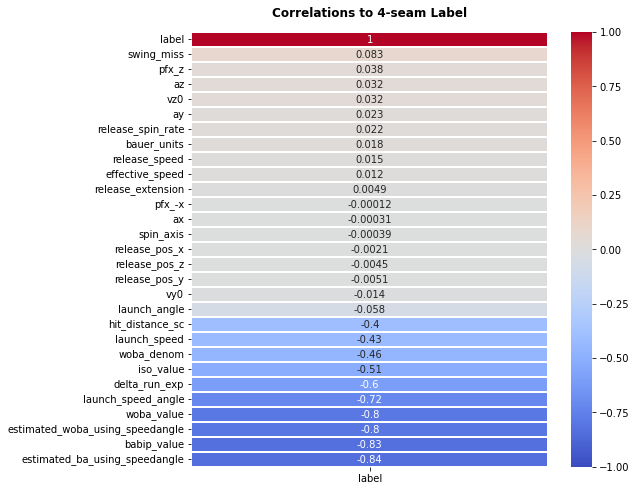

In [18]:
plt.figure(figsize = (8, 8))
sns.heatmap(X_ff.corr()[['label']].sort_values(('label'), ascending = False), 
            annot = True, cmap = 'coolwarm', vmin = -1, vmax = 1, linewidths = 2)
plt.title('Correlations to 4-seam Label', fontweight = 'bold', pad = 15);

Positively correlated with label

Negatively correlated with lablel so the better the negatives the lower the run value / 100

In [19]:
X = X_ff.drop(columns = ['label'])
y = X_ff['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)

lr = LogisticRegression(random_state = 1)
lr.fit(X_train, y_train)

pred_ff = lr.predict(X_test)
pred_probs_ff = lr.predict_proba(X_test)[:,1]

print('Train score:', round(lr.score(X_train, y_train), 2))
print('Test score:', round(lr.score(X_test, y_test), 2)) 
print('Cross val score', round(cross_val_score(lr, X_train, y_train).mean(), 4))

Train score: 0.98
Test score: 0.98
Cross val score 0.9798


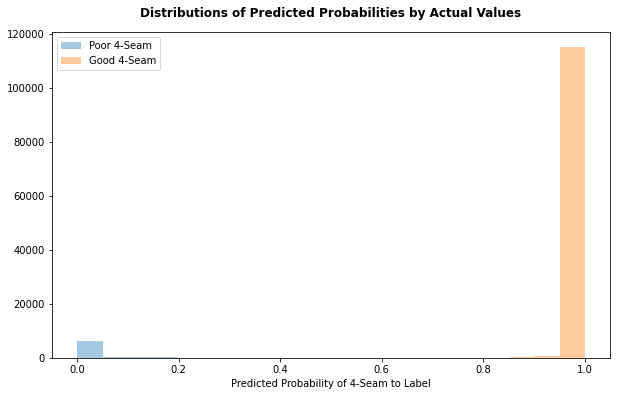

In [20]:
pred_ff_df = pd.DataFrame({'true_values': y_test, 'pred_probs': pred_probs_ff})
labels = ('Poor 4-Seam', 'Good 4-Seam')
plt.figure(figsize = (10, 6))
for group in pred_ff_df.groupby('true_values'):
    sns.distplot(group[1], kde = False, bins = 20)
plt.xlabel('Predicted Probability of 4-Seam to Label')
plt.legend(labels)
plt.title('Distributions of Predicted Probabilities by Actual Values', fontweight = 'bold', pad = 15);

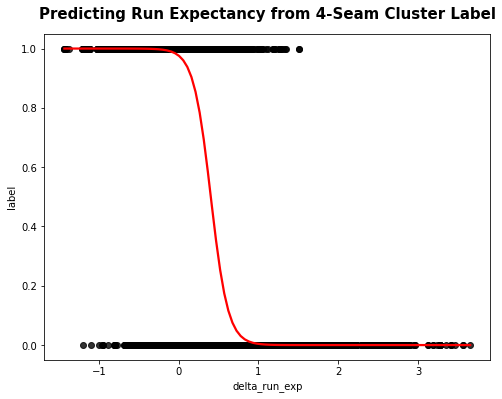

In [21]:
plt.figure(figsize = (8, 6))
sns.regplot(x = X_ff['delta_run_exp'], y = X_ff['label'], data = X_ff, logistic = True, ci = None,
            scatter_kws = {'color': 'black'}, line_kws = {'color': 'red'})
plt.title('Predicting Run Expectancy from 4-Seam Cluster Label', fontweight = 'bold', fontsize = 15, pad = 15);

## Logistic Regression - Cutter

### Heatmap of Features - Cutter

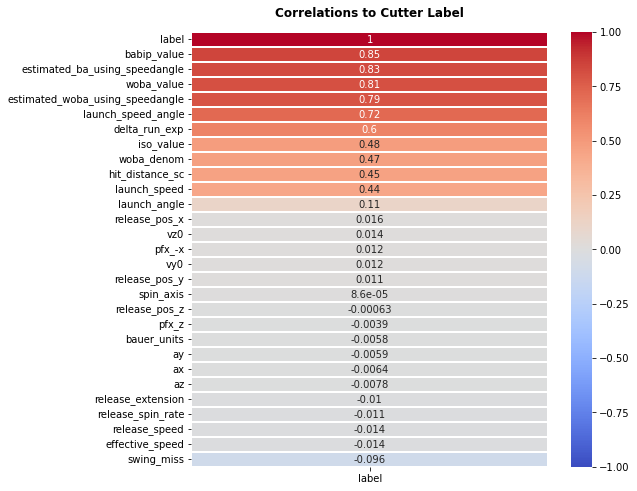

In [22]:
plt.figure(figsize = (8, 8))
sns.heatmap(X_fc.corr()[['label']].sort_values(('label'), ascending = False), 
            annot = True, cmap = 'coolwarm', vmin = -1, vmax = 1, linewidths = 2)
plt.title('Correlations to Cutter Label', fontweight = 'bold', pad = 15);

In [23]:
X = X_fc.drop(columns = ['label'])
y = X_fc['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)

lr = LogisticRegression(random_state = 1)
lr.fit(X_train, y_train)

pred_fc = lr.predict(X_test)
pred_probs_fc = lr.predict_proba(X_test)[:,1]

print('Train score:', round(lr.score(X_train, y_train), 2))
print('Test score:', round(lr.score(X_test, y_test), 2)) 
print('Cross val score', round(cross_val_score(lr, X_train, y_train).mean(), 4))

Train score: 0.98
Test score: 0.98
Cross val score 0.9678


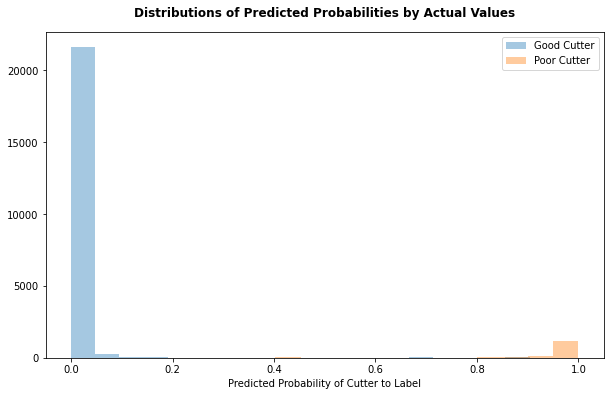

In [24]:
pred_fc_df = pd.DataFrame({'true_values': y_test, 'pred_probs': pred_probs_fc})
labels = ('Good Cutter', 'Poor Cutter')
plt.figure(figsize = (10, 6))
for group in pred_fc_df.groupby('true_values'):
    sns.distplot(group[1], kde = False, bins = 20)
plt.xlabel('Predicted Probability of Cutter to Label')
plt.legend(labels)
plt.title('Distributions of Predicted Probabilities by Actual Values', fontweight = 'bold', pad = 15);

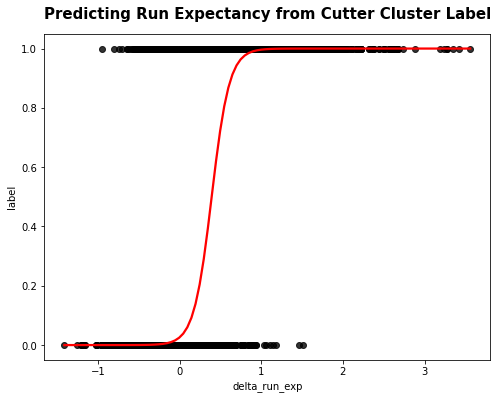

In [25]:
plt.figure(figsize = (8, 6))
sns.regplot(x = X_fc['delta_run_exp'], y = X_fc['label'], data = X_fc, logistic = True, ci = None,
            scatter_kws = {'color': 'black'}, line_kws = {'color': 'red'})
plt.title('Predicting Run Expectancy from Cutter Cluster Label', fontweight = 'bold', fontsize = 15, pad = 15);

## Logistic Regression - Sinker

### Heatmap of Features - Sinker

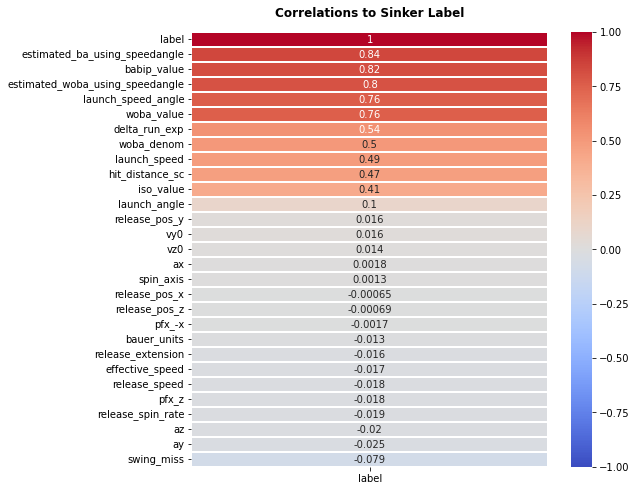

In [26]:
plt.figure(figsize = (8, 8))
sns.heatmap(X_si.corr()[['label']].sort_values(('label'), ascending = False), 
            annot = True, cmap = 'coolwarm', vmin = -1, vmax = 1, linewidths = 2)
plt.title('Correlations to Sinker Label', fontweight = 'bold', pad = 15);

In [27]:
X = X_si.drop(columns = ['label'])
y = X_si['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)

lr = LogisticRegression(random_state = 1)
lr.fit(X_train, y_train)

pred_si = lr.predict(X_test)
pred_probs_si = lr.predict_proba(X_test)[:,1]

print('Train score:', round(lr.score(X_train, y_train), 2))
print('Test score:', round(lr.score(X_test, y_test), 2)) 
print('Cross val score', round(cross_val_score(lr, X_train, y_train).mean(), 4))

Train score: 0.98
Test score: 0.98
Cross val score 0.9767


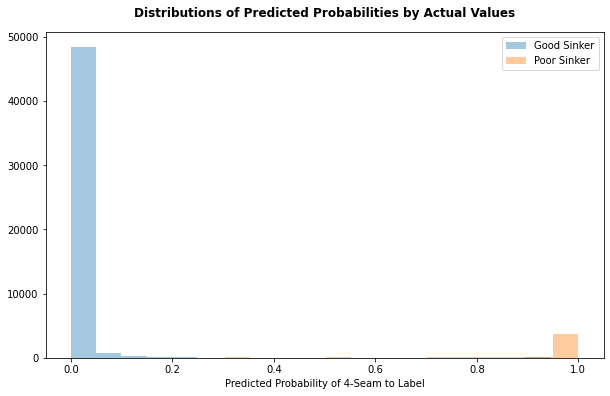

In [28]:
pred_si_df = pd.DataFrame({'true_values': y_test, 'pred_probs': pred_probs_si})
labels = ('Good Sinker', 'Poor Sinker')
plt.figure(figsize = (10, 6))
for group in pred_si_df.groupby('true_values'):
    sns.distplot(group[1], kde = False, bins = 20)
plt.xlabel('Predicted Probability of 4-Seam to Label')
plt.legend(labels)
plt.title('Distributions of Predicted Probabilities by Actual Values', fontweight = 'bold', pad = 15);

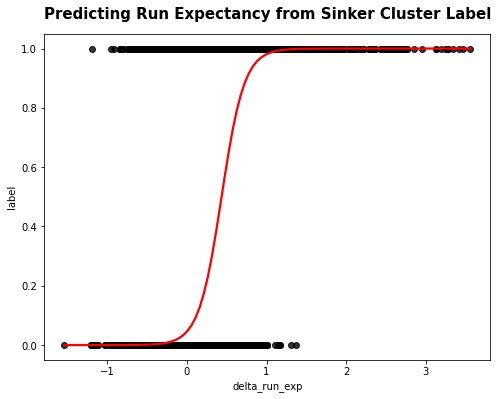

In [29]:
plt.figure(figsize = (8, 6))
sns.regplot(x = X_si['delta_run_exp'], y = X_si['label'], data = X_si, logistic = True, ci = None,
            scatter_kws = {'color': 'black'}, line_kws = {'color': 'red'})
plt.title('Predicting Run Expectancy from Sinker Cluster Label', fontweight = 'bold', fontsize = 15, pad = 15);

## Logistic Regression - Slider

### Heatmap of Features - Slider

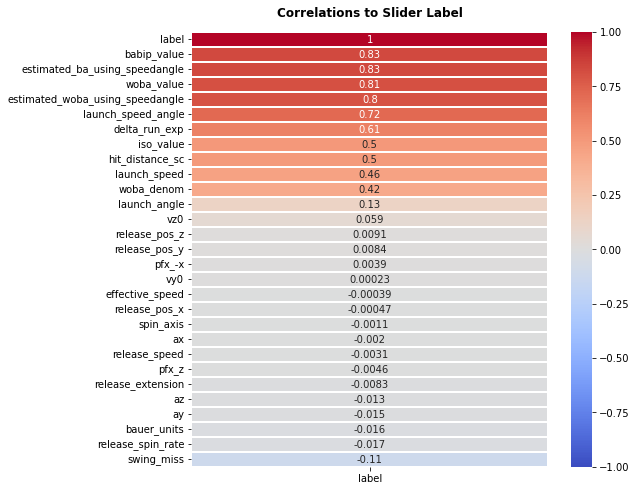

In [30]:
plt.figure(figsize = (8, 8))
sns.heatmap(X_sl.corr()[['label']].sort_values(('label'), ascending = False), 
            annot = True, cmap = 'coolwarm', vmin = -1, vmax = 1, linewidths = 2)
plt.title('Correlations to Slider Label', fontweight = 'bold', pad = 15);

In [31]:
X = X_sl.drop(columns = ['label'])
y = X_sl['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)

lr = LogisticRegression(random_state = 1)
lr.fit(X_train, y_train)

pred_sl = lr.predict(X_test)
pred_probs_sl = lr.predict_proba(X_test)[:,1]

print('Train score:', round(lr.score(X_train, y_train), 2))
print('Test score:', round(lr.score(X_test, y_test), 2)) 
print('Cross val score', round(cross_val_score(lr, X_train, y_train).mean(), 4))

Train score: 0.97
Test score: 0.97
Cross val score 0.977


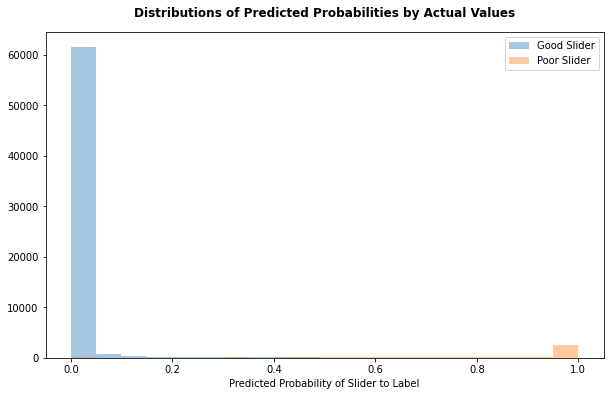

In [32]:
pred_sl_df = pd.DataFrame({'true_values': y_test, 'pred_probs': pred_probs_sl})
labels = ('Good Slider', 'Poor Slider')
plt.figure(figsize = (10, 6))
for group in pred_sl_df.groupby('true_values'):
    sns.distplot(group[1], kde = False, bins = 20)
plt.xlabel('Predicted Probability of Slider to Label')
plt.legend(labels)
plt.title('Distributions of Predicted Probabilities by Actual Values', fontweight = 'bold', pad = 15);

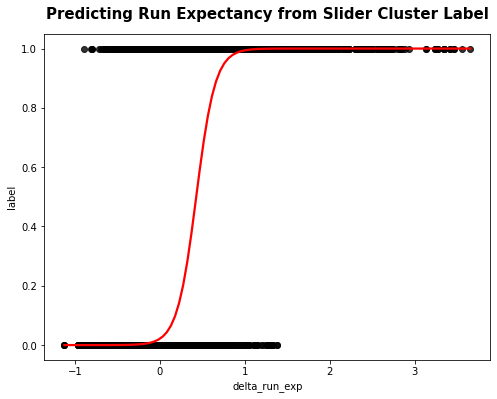

In [33]:
plt.figure(figsize = (8, 6))
sns.regplot(x = X_sl['delta_run_exp'], y = X_sl['label'], data = X_sl, logistic = True, ci = None,
            scatter_kws = {'color': 'black'}, line_kws = {'color': 'red'})
plt.title('Predicting Run Expectancy from Slider Cluster Label', fontweight = 'bold', fontsize = 15, pad = 15);

## Logistic Regression - Curveball

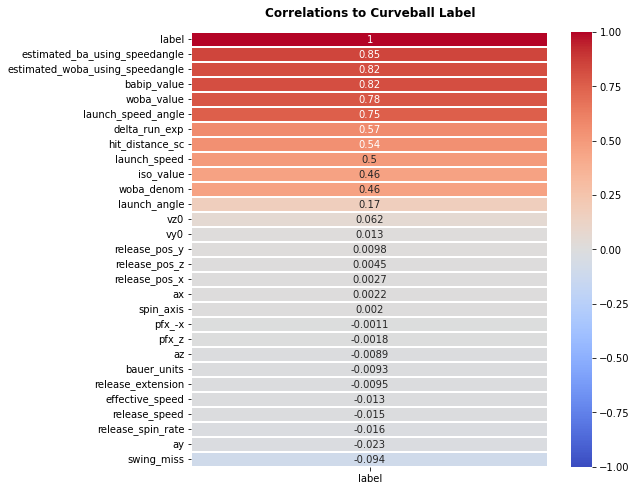

In [34]:
plt.figure(figsize = (8, 8))
sns.heatmap(X_cu.corr()[['label']].sort_values(('label'), ascending = False), 
            annot = True, cmap = 'coolwarm', vmin = -1, vmax = 1, linewidths = 2)
plt.title('Correlations to Curveball Label', fontweight = 'bold', pad = 15);

In [35]:
X = X_cu.drop(columns = ['label'])
y = X_cu['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)

lr = LogisticRegression(random_state = 1)
lr.fit(X_train, y_train)

pred_cu = lr.predict(X_test)
pred_probs_cu = lr.predict_proba(X_test)[:,1]

print('Train score:', round(lr.score(X_train, y_train), 2))
print('Test score:', round(lr.score(X_test, y_test), 2)) 
print('Cross val score', round(cross_val_score(lr, X_train, y_train).mean(), 4))

Train score: 0.98
Test score: 0.98
Cross val score 0.9801


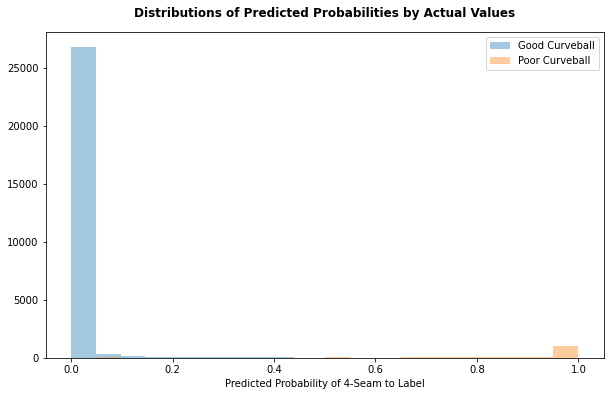

In [36]:
pred_cu_df = pd.DataFrame({'true_values': y_test, 'pred_probs': pred_probs_cu})
labels = ('Good Curveball', 'Poor Curveball')
plt.figure(figsize = (10, 6))
for group in pred_cu_df.groupby('true_values'):
    sns.distplot(group[1], kde = False, bins = 20)
plt.xlabel('Predicted Probability of 4-Seam to Label')
plt.legend(labels)
plt.title('Distributions of Predicted Probabilities by Actual Values', fontweight = 'bold', pad = 15);

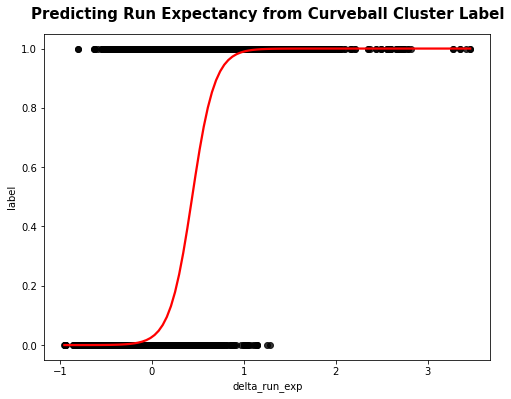

In [37]:
plt.figure(figsize = (8, 6))
sns.regplot(x = X_cu['delta_run_exp'], y = X_cu['label'], data = X_cu, logistic = True, ci = None,
            scatter_kws = {'color': 'black'}, line_kws = {'color': 'red'})
plt.title('Predicting Run Expectancy from Curveball Cluster Label', fontweight = 'bold', fontsize = 15, pad = 15);

## Logistic Regression - Changeup

### Heatmap of Features - Changeup

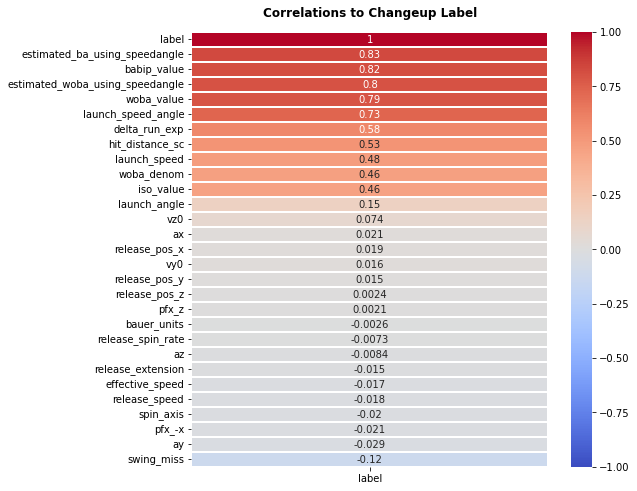

In [38]:
plt.figure(figsize = (8, 8))
sns.heatmap(X_ch.corr()[['label']].sort_values(('label'), ascending = False), 
            annot = True, cmap = 'coolwarm', vmin = -1, vmax = 1, linewidths = 2)
plt.title('Correlations to Changeup Label', fontweight = 'bold', pad = 15);

In [39]:
X = X_ch.drop(columns = ['label'])
y = X_ch['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)

lr = LogisticRegression(random_state = 1)
lr.fit(X_train, y_train)

pred_ch = lr.predict(X_test)
pred_probs_ch = lr.predict_proba(X_test)[:,1]

print('Train score:', round(lr.score(X_train, y_train), 2))
print('Test score:', round(lr.score(X_test, y_test), 2)) 
print('Cross val score', round(cross_val_score(lr, X_train, y_train).mean(), 4))

Train score: 0.98
Test score: 0.98
Cross val score 0.977


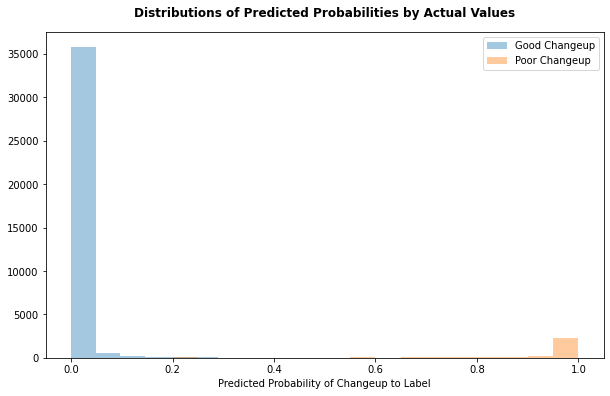

In [40]:
pred_ch_df = pd.DataFrame({'true_values': y_test, 'pred_probs': pred_probs_ch})
labels = ('Good Changeup', 'Poor Changeup')
plt.figure(figsize = (10, 6))
for group in pred_ch_df.groupby('true_values'):
    sns.distplot(group[1], kde = False, bins = 20)
plt.xlabel('Predicted Probability of Changeup to Label');
plt.legend(labels)
plt.title('Distributions of Predicted Probabilities by Actual Values', fontweight = 'bold', pad = 15);

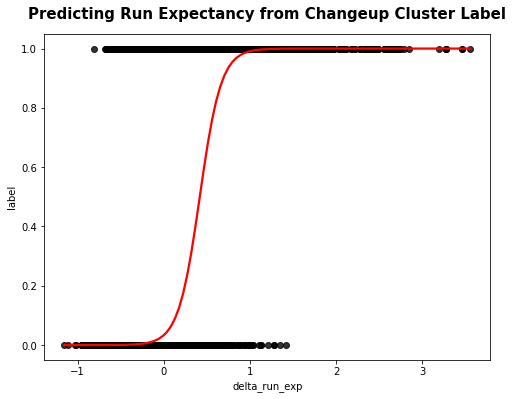

In [41]:
plt.figure(figsize = (8, 6))
sns.regplot(x = X_ch['delta_run_exp'], y = X_ch['label'], data = X_ch, logistic = True, ci = None,
            scatter_kws = {'color': 'black'}, line_kws = {'color': 'red'})
plt.title('Predicting Run Expectancy from Changeup Cluster Label', fontweight = 'bold', fontsize = 15, pad = 15);